In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Linear model and loss minimization
## Note
This code demo covers additional material, which is intended for students interested in more in-depth knowledge.
## Problem
We can estimate the $\theta$ coefficients by minimizing the empirical risk
$$R_{emp}(f)=\frac{1}{n}\sum_{i=1}^n L(y^{(i)},f(x^{(i)}))$$
of the model over $\theta$. With quadratic loss, this yields
$$R_{emp}(f)=\frac{1}{n}\sum_{i=1}^n (y^{(i)}-(x^{(i)})^T\theta)$$
This can be written in matrix notation as:
$$R_{emp}(f)=\frac{1}{n}(X\theta-y)^T(X\theta-y)=\frac{1}{n}(\theta^TX^TX\theta-2\theta^TX^Ty+y^Ty)$$
The problem then becomes finding $\hat{\theta}$ such that
$$\hat{\theta}=\underset{\theta}{\operatorname{argmin}} R_{emp}(f)$$

## Solution
- we can solve this kind of minimization problem using an iterative technique termed Gradient Descent
- this is an extremely important technique that is applied - in many variants - to solve the optimization problem when optimizing many kinds of learners.
- Note: An analytic solution exists for the quadratic loss, s.t.
$$\hat{\theta}=(X^TX)^{-1}X^Ty$$

## Gradient Descent
The Gradient Descent method follows this algorithm:
1. Initialize $\theta^{[0]}$ (randomly) and calculate the gradient of the empirical risk with respect to θ, for example for the squared error loss:
$$\frac{\partial R_{emp}(f)}{\partial\theta} = \frac{\partial}{\partial\theta}\frac{1}{n}(\theta^TX^TX\theta-2\theta^TX^Ty+y^Ty)=\frac{2}{n}X^T[X\theta^{[t]}-y]$$
Now iterate these two steps
2. Evaluate the gradient at the current value of the parameter vector $\theta^{[t]}$ :
$$\left.\frac{\partial R_{e m p}(f)}{\partial \theta}\right|_{\theta=\theta[t]}=\frac{2}{n} X^{T}\left[X \theta^{[t]}-y\right]$$
3. Update the estimate for $\theta$ using :
$$\theta^{[t+1]}=\theta^{[t]}-\left.\lambda \frac{\partial R_{e m p}(f)}{\partial \theta}\right|_{\theta=\theta[t]}$$

- The stepsize or learning rate parameter λ controls the size of the updates per iteration t.
- We stop if the differences between successive updates of θ are below a certain threshold or once a maximum number of iterations is reached.
- Many variants of gradient descent exist that either
    - develop clever ways on how to choose good stepsizes (maybe even dependent on t),
    - and/or how to compute (approximations to) the gradient effectively,
    - and/or even adapt the direction of the update itself by taking into account, for example, the previously used update directions or the second derivatives of the empirical risk (i.e., the curvature of the risk surface). . . .

## Implementation

First we calculate the risk for squared loss and it's gradient as two seperate functions:

In [2]:
def risk_quadratic(theta,y,X):
    residual = X.dot(theta)-y
    return residual.T.dot(residual)/len(y)

In [3]:
def gradient_quadratic(theta,y,X):
    residual = X.dot(theta)-y
    return X.T.dot(residual)*2/len(y)

In [4]:
def gradient_descent(y,X,theta,
                    loss_fn=risk_quadratic,
                    grad_fn=gradient_quadratic,
                    learning_rate=0.005,
                    max_iter=2000):

    loss_storage=[]
    theta_storage=[]
    
    loss_storage.append(loss_fn(theta,y,X))
    theta_storage.append(theta)
    
    for i in range(max_iter):
        theta = theta - learning_rate * grad_fn(theta,y,X)
        loss = loss_fn(theta,y,X)
        loss_storage.append(loss)
        theta_storage.append(theta)
        
    return loss_storage,theta_storage

Simulated Data`

In [5]:
np.random.seed(42)
n=100
max_iter=2000

intercept = np.ones((n,1))
x1 = np.random.uniform(-3,5,n).reshape(n,1)
x2 = np.random.uniform(-2,10,n).reshape(n,1)

X = np.hstack([intercept,x1,x2])
theta_true = np.array([2,0.5,0.5])
y=X.dot(theta_true) + np.random.normal(size=n)

theta_init = np.zeros_like(theta_true)

In [6]:
out = gradient_descent(y,X,theta_init,max_iter=max_iter)

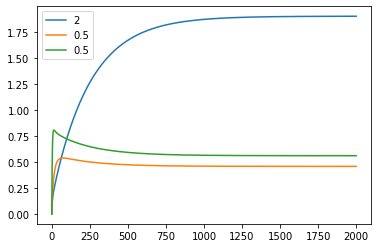

In [7]:
plt.plot(out[1])
plt.legend(['2','0.5','0.5']);

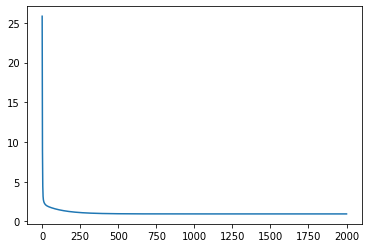

In [8]:
plt.plot(out[0]);

In [9]:
theta_final = out[1][-1]
theta_final

array([1.90181527, 0.45731982, 0.56001574])

## Stopping criterion
By looking at the figures we see that the empirical risk quickly starts to stagnate and is not improving much
more, i.e., we are doing unnecessary computations. Because of this it makes sense to use a stopping criterion.
One commonly used stopping criterion consists in checking if θ is not changing notably, e.g. that for an $\epsilon$ > 0

$$\left\|\theta^{[t+1]}-\theta^{[t]}\right\|_{2}<\epsilon$$

In [10]:
def gradient_descent_threshold(y,X,theta,
                              loss_fn=risk_quadratic,
                              grad_fn=gradient_quadratic,
                              learning_rate=0.005,
                              max_iter=2000,
                              threshold=1e-3):

    loss_storage=[]
    theta_storage=[]
    
    loss_storage.append(loss_fn(theta,y,X))
    theta_storage.append(theta)
    
    for i in range(max_iter):
        theta = theta - learning_rate * grad_fn(theta,y,X)
        loss = loss_fn(theta,y,X)
        
        if (i>1)&(np.sqrt(np.sum((theta_storage[-1]-theta)**2))<threshold):
            print(f'threshold reached. Breaking at {i}-th iteration')
            break
        loss_storage.append(loss)
        theta_storage.append(theta)
        
    return loss_storage,theta_storage

In [11]:
out = gradient_descent_threshold(y,X,theta_init,max_iter=max_iter)

threshold reached. Breaking at 487-th iteration


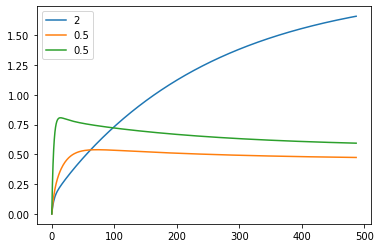

In [12]:
plt.plot(out[1])
plt.legend(['2','0.5','0.5']);

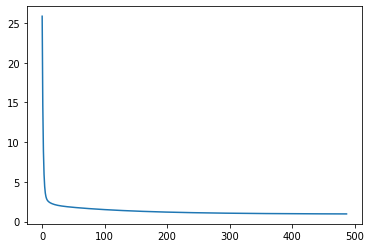

In [13]:
plt.plot(out[0]);

In [14]:
theta_final = out[1][-1]
theta_final

array([1.65821689, 0.47353795, 0.59343386])

## Stepsize
We notice that our implementation depends on the hyperparameter stepsize λ. Our implementation could be improved by doing an inner optimization for the stepsize λ, s.t. we follow the direction of the gradient until
the function starts to increase again. For this task we can use the optim function. This is called a line search algorithm, because we’re looking for a (local) minimum along the line of steepest descent.

In [15]:
def BacktrackingLineSearch(f, df, x, p, df_x = None, f_x = None, args = (),
        alpha = 0.0001, beta = 0.9, eps = 1e-15, Verbose = False):
    """
    source : https://gist.github.com/jiahao/1561144
    
    Backtracking linesearch
    f: function
    df: gradient function
    x: current point
    p: direction of search
    df_x: gradient at x
    f_x = f(x) (Optional)
    args: optional arguments to f (optional)
    alpha, beta: backtracking parameters
    eps: (Optional) quit if norm of step produced is less than this
    Verbose: (Optional) Print lots of info about progress
    
    Reference: Nocedal and Wright 2/e (2006), p. 37
    
    Usage notes:
    -----------
    Recommended for Newton methods; less appropriate for quasi-Newton or conjugate gradients
    """

    if f_x is None:
        f_x = f(x, *args)
    if df_x is None:
        df_x = df(x, *args)

    assert df_x.T.shape == p.shape
    assert 0 < alpha < 1, 'Invalid value of alpha in backtracking linesearch'
    assert 0 < beta < 1, 'Invalid value of beta in backtracking linesearch'

    derphi = np.dot(df_x, p)

    assert derphi.shape == (1, 1) or derphi.shape == ()
    assert derphi < 0, 'Attempted to linesearch uphill'

    stp = 1.0
    fc = 0
    len_p = np.linalg.norm(p)


    #Loop until Armijo condition is satisfied
    while f(x + stp * p, *args) > f_x + alpha * stp * derphi:
        stp *= beta
        fc += 1
        if Verbose: print('linesearch iteration', fc, ':', stp, f(x + stp * p, *args), f_x + alpha * stp * derphi)
        if stp * len_p < eps:
            print('Step is  too small, stop')
            break
    #if Verbose: print 'linesearch iteration 0 :', stp, f_x, f_x

    if Verbose: print('linesearch done')
    #print fc, 'iterations in linesearch'
    return stp

In [16]:
def gradient_descent_opt_stepsize(y,X,theta,
                                  loss_fn=risk_quadratic,
                                  grad_fn=gradient_quadratic,
                                  max_iter=2000,
                                  threshold=1e-3):

    loss_storage=[]
    theta_storage=[]
    lr_storage=[]
    
    loss_storage.append(loss_fn(theta,y,X))
    theta_storage.append(theta)
    
    for i in range(max_iter):
        lr_opt = BacktrackingLineSearch(loss_fn,grad_fn,theta,-grad_fn(theta,y,X),args=(y,X))
        theta = theta - lr_opt * grad_fn(theta,y,X)
        loss = loss_fn(theta,y,X)
        
        if (i>1)&(np.sqrt(np.sum((theta_storage[-1]-theta)**2))<threshold):
            print(f'threshold reached. Breaking at {i}-th iteration')
            break
        loss_storage.append(loss)
        theta_storage.append(theta)
        lr_storage.append(lr_opt)
        
    return loss_storage,theta_storage,lr_storage

In [17]:
out = gradient_descent_opt_stepsize(y,X,theta_init,max_iter=max_iter)

threshold reached. Breaking at 674-th iteration


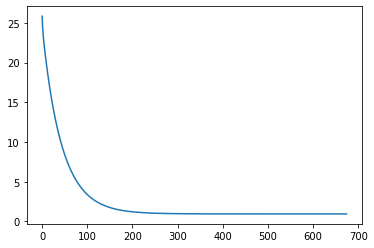

In [18]:
plt.plot(out[0]);

## Comparison with scikit-learn 

In [19]:
clf = LinearRegression().fit(X, y)

In [20]:
clf.intercept_

1.9023482760815824

In [21]:
clf.coef_

array([0.        , 0.45728433, 0.55994262])

## Comparison with exact solution

In [22]:
np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

array([1.90234828, 0.45728433, 0.55994262])